In [1]:
# Add local scripts to module search path
import sys
import os
sys.path.append(os.path.realpath('../toliman-proper'))

In [2]:
from proper_cache import clear_all_cached

if False:
    clear_all_cached()

/suphys/bjef8061/.local/lib/python3.5/site-packages/pyfits-3.5-py3.5-linux-x86_64.egg/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [3]:
from proper_tools import form_detector_image
from spirals import binarized_ringed_flipped

prescription = 'prescription_rc_quad'

beam_ratio = 0.4
gridsize = 2048
def binarized_ringed_650(r, phi):
    phase = 650.*1e-9*0.5
    return binarized_ringed_flipped(r, phi, phase)

toliman_settings = {
                    'diam': 0.001 * 2. * 150, 
                    'm1_fl': 571.7300 / 1000.,
                    'm1_m2_sep': 549.240/1000.,
                    'm2_fl': -23.3800/1000.,
                    'bfl': 590.000 / 1000., 
                    'm2_rad': 5.9 / 1000., 
                    'm2_strut_width': 0.01,
                    'm2_supports': 5,
                    'beam_ratio': beam_ratio,
                    'tilt_x': 0.00,
                    'tilt_y': 0.00,
                    'opd_func': binarized_ringed_650,
                    'm1_hole_rad':0.025,
                    'use_caching':True
                    }

detector_pitch = 11.0e-6 # m/pixel on detector
npixels = 512 # Size of detector, in pixels

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import numpy as np
def view_psf(imarray, pitch_mm, viewport_mm,vmin=None,vmax=None,title=None):
    c = imarray.shape[0]/2. # Assume scaled image
    w = viewport_mm/pitch_mm
    im = plt.imshow(imarray[int(c-w):int(c+w),int(c-w):int(c+w)],cmap='viridis', extent=[x*pitch_mm for x in [-w,w,-w,w]], norm=LogNorm(),vmin=vmin, vmax=vmax)
    if title is not None:
        plt.title(title)
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)


In [5]:
viewport = 1. # mm

# Monochromatic (600nm)

In [6]:
wl_vals = [0.6]
# [5.999989e-01, 6.026560e-01, 6.068356e-01, 6.119202e-01, 6.173624e-01, 6.226281e-01, 6.270944e-01, 6.300010e-01 ]
wl_weights = [1.]
#[5.3770e-02, 1.1224e-01, 1.5056e-01, 1.7034e-01, 1.7342e-01, 1.5861e-01, 1.2166e-01, 5.9360e-02 ]

In [7]:
# First source, on axis
source_a = {
            'wavelengths': wl_vals,
            'weights': wl_weights,
            'settings': toliman_settings
            }

## Proper PSF using single source and `form_detector_image` 

In [8]:
image = form_detector_image(prescription, [source_a], gridsize, detector_pitch, npixels)

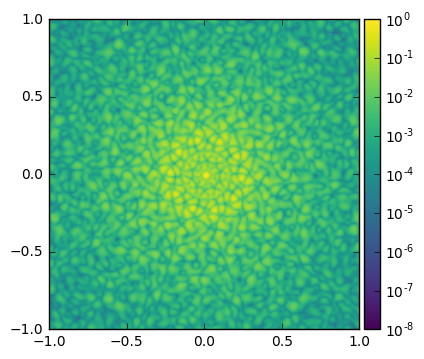

In [9]:
%matplotlib inline
view_psf(image/image.max(axis=None), detector_pitch/1e-3, 1., vmin=1e-8)
plt.show()

## Zemax reference

In [10]:
zemax = np.load('../zemax_examples/toliman-RC-f50_SpiralPupil_psf_0deg_600nm_4mm.npy')

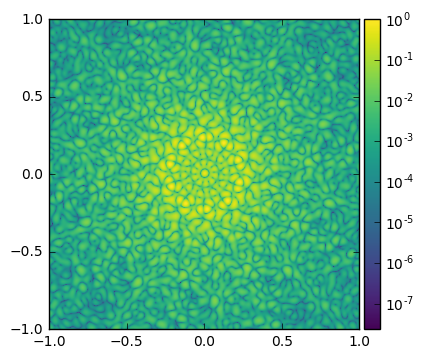

In [11]:
%matplotlib inline
view_psf(zemax, 4e-3, 1.)
plt.show()

In [12]:
# Resolution is too high, so downsample.
import proper
from proper_tools import fix_prop_pixellate
src_pitch = 4e-6 # specified in source file

mag = src_pitch / detector_pitch
print("Rescaling from sampling of {} to {}, magnification of {}".format(src_pitch, detector_pitch, mag))
#zemax_resized = proper.prop_magnify(zemax, mag, CONSERVE = False, AMP_CONSERVE=False)
zemax_resized = fix_prop_pixellate(zemax, src_pitch, detector_pitch)

Rescaling from sampling of 4e-06 to 1.1e-05, magnification of 0.36363636363636365


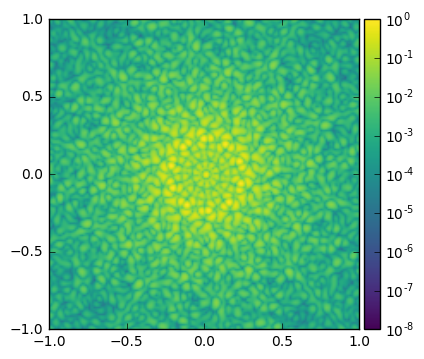

In [13]:
%matplotlib inline
view_psf(zemax_resized/zemax_resized.max(axis=None), detector_pitch/1e-3, 1., vmin=1e-8)
plt.show()

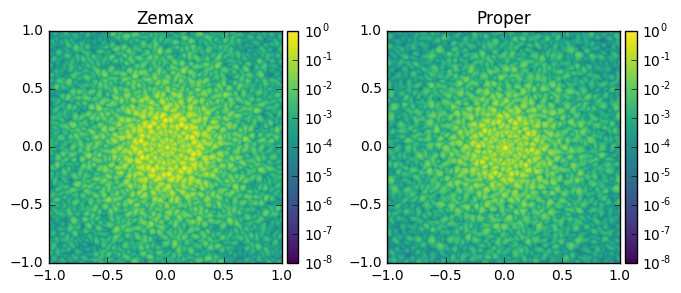

In [14]:
#Side by side plot
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
fig, axes = plt.subplots(1, 2, figsize=(8,3))
plt.axes(axes[0])
view_psf(zemax_resized/zemax_resized.max(axis=None), detector_pitch/1e-3, 1., vmin=1e-8, title='Zemax')

plt.axes(axes[1])
view_psf(image/image.max(axis=None), detector_pitch/1e-3, 1., vmin=1e-8, title='Proper')

plt.show()

# Polychromatic

In [15]:
wl_vals_multi = [5.999989e-01, 6.026560e-01, 6.068356e-01, 6.119202e-01, 6.173624e-01, 6.226281e-01, 6.270944e-01, 6.300010e-01 ]
wl_weights_multi = [5.3770e-02, 1.1224e-01, 1.5056e-01, 1.7034e-01, 1.7342e-01, 1.5861e-01, 1.2166e-01, 5.9360e-02 ]

In [16]:
# First source, on axis
source_a_multi = {
            'wavelengths': wl_vals_multi,
            'weights': wl_weights_multi,
            'settings': toliman_settings
            }

## Proper PSF using single source and `form_detector_image` 

In [17]:
image_multi = form_detector_image(prescription, [source_a_multi], gridsize, detector_pitch, npixels)

## Zemax reference

In [18]:
zemax_multi = np.load('../zemax_examples/toliman-RC-f50_SpiralPupil_psf_0deg_600-630-12waves_4mm.npy')
# Resolution is too high, so downsample.
src_pitch = 4e-6 # specified in source file

mag = src_pitch / detector_pitch
print("Rescaling from sampling of {} to {}, magnification of {}".format(src_pitch, detector_pitch, mag))
#zemax_multi_resized = proper.prop_magnify(zemax_multi, mag, CONSERVE = False, AMP_CONSERVE=False)
zemax_multi_resized = fix_prop_pixellate(zemax_multi, src_pitch, detector_pitch)

Rescaling from sampling of 4e-06 to 1.1e-05, magnification of 0.36363636363636365


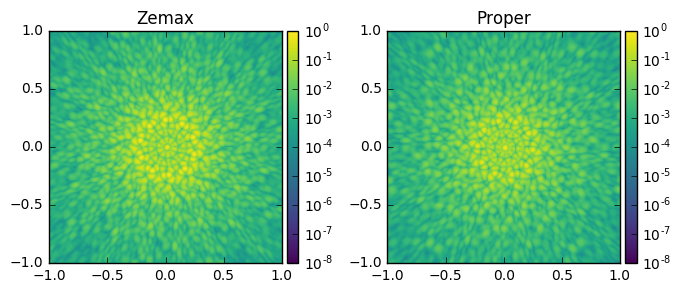

In [19]:
#Side by side plot
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
fig, axes = plt.subplots(1, 2, figsize=(8,3))
plt.axes(axes[0])
view_psf(zemax_multi_resized/zemax_multi_resized.max(axis=None), detector_pitch/1e-3, 1., vmin=1e-8, title='Zemax')

plt.axes(axes[1])
view_psf(image_multi/image_multi.max(axis=None), detector_pitch/1e-3, 1., vmin=1e-8, title='Proper')

plt.show()